# Disease detection from X-ray

## Import required libraries

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model

Load the train dataset

In [2]:
xray_directory = './train'

In [3]:
os.listdir(xray_directory)

['.DS_Store', '0', '1', '3', '2']

Let's create a image generator to transform our data image  

In [4]:
image_generator = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


We have 133 images of each class, so in total we have 532 images

In [6]:
train_images, train_labels = next(train_generator)

Our dataset train has 4 images each batch

In [7]:
train_images.shape

(4, 256, 256, 3)

Our target data are encoded to represent each class of disease, as below:

In [8]:
# Covid19 - 1 0 0 0
# Normal  - 0 1 0 0
# Viral   - 0 0 1 0
# Bacterial - 0 0 0 1
labels_names = {0: 'Covid-19', 1: 'Normal', 2: 'Viral Pneunomia', 3: 'Bacterial Pneunomia'}

In [9]:
train_labels

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

## Viewing the data

Let's see each image with its target

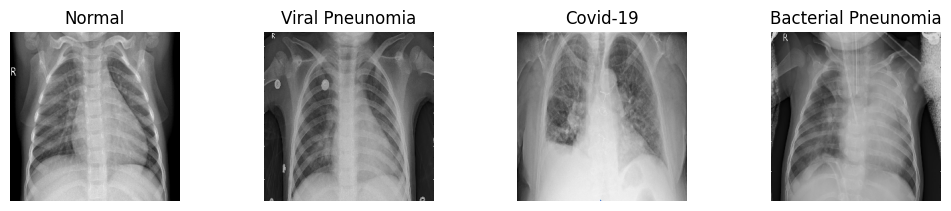

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(12, 12))
axes = axes.ravel()
for i in np.arange(0, 4):
    axes[i].imshow(train_images[i])
    axes[i].set_title(labels_names[np.argmax(train_labels[i])])
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)
plt.show()

## Load the neural network pre-trained, in this example we'll use a ResNet50 

In [11]:
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_tensor = Input(shape=(256,256,3)))

In [12]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [13]:
len(base_model.layers)

175

In [14]:
for layer in base_model.layers[:-10]:
    layers.trainable = False

## Builds our custom model that will be coupled to the pre-trained model

In [15]:
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation = 'softmax')(head_model)

In [16]:
model = Model(inputs = base_model.input, outputs = head_model)

In [17]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay=1e-6),
              metrics = ['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
checkpointer = ModelCheckpoint(filepath='weights.hdf5')

In [19]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory=xray_directory,
                                                      shuffle = True, target_size=(256, 256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [20]:
history = model.fit_generator(train_generator, epochs = 15, 
                              callbacks=[checkpointer])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
133/133 [==============================] - 477s 3s/step - loss: 1.0455 - accuracy: 0.7199


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
133/133 [==============================] - 437s 3s/step - loss: 0.4820 - accuracy: 0.8703
Epoch 3/15
133/133 [==============================] - 404s 3s/step - loss: 0.4954 - accuracy: 0.8684
Epoch 4/15
133/133 [==============================] - 393s 3s/step - loss: 0.2904 - accuracy: 0.9211
Epoch 5/15
133/133 [==============================] - 393s 3s/step - loss: 0.1854 - accuracy: 0.9624
Epoch 6/15
133/133 [==============================] - 406s 3s/step - loss: 0.1842 - accuracy: 0.9586
Epoch 7/15
133/133 [==============================] - 406s 3s/step - loss: 0.1925 - accuracy: 0.9662
Epoch 8/15
133/133 [==============================] - 406s 3s/step - loss: 0.1419 - accuracy: 0.9887
Epoch 9/15
133/133 [==============================] - 411s 3s/step - loss: 0.1562 - accuracy: 0.9737
Epoch 10/15
133/133 [==============================] - 399s 3s/step - loss: 0.0396 - accuracy: 0.9962
Epoch 11/15
133/133 [==============================] - 450s 3s/step - loss: 0.0765 - accur

## Neural network evaluation

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Error and accuracy on the train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy and error')
plt.legend(['Accuracy', 'Error']);

Load the test dataset

In [23]:
test_directory = './test'

In [24]:
os.listdir(test_directory)

['0', '1', '3', '2']

In [25]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                              shuffle = True, target_size = (256, 256),
                                              class_mode = 'categorical')

Found 40 images belonging to 4 classes.


In [26]:
evaluate = model.evaluate_generator(test_generator)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Error x accurracy

In [27]:
evaluate

[12.14382266998291, 0.699999988079071]

Now, we going predict the value to the images from test dataset

In [28]:
prediction = []
original = []
image = []
for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img, (256, 256))
        image.append(img)
        img = img / 255
        img = img.reshape(-1, 256, 256, 3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

In [29]:
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 2, 2, 2, 2, 3, 0, 1, 1, 1, 1, 1, 3, 0, 3, 3, 3, 3, 3, 0]


In [30]:
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


Calculates the accuracy in the model

In [31]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [32]:
accuracy_score(original, prediction)

0.7

Now, we can plot the Prediction vs the Real value from the X-Ray

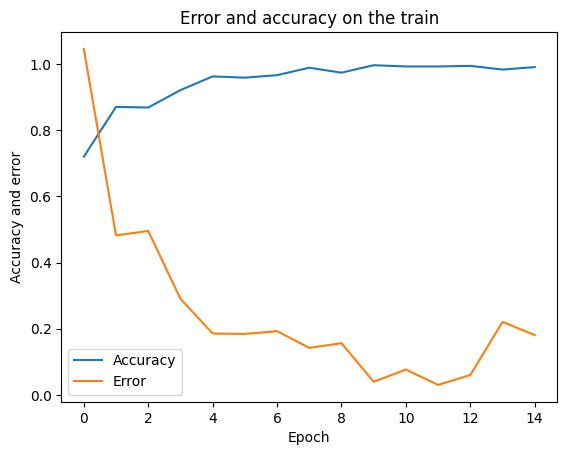

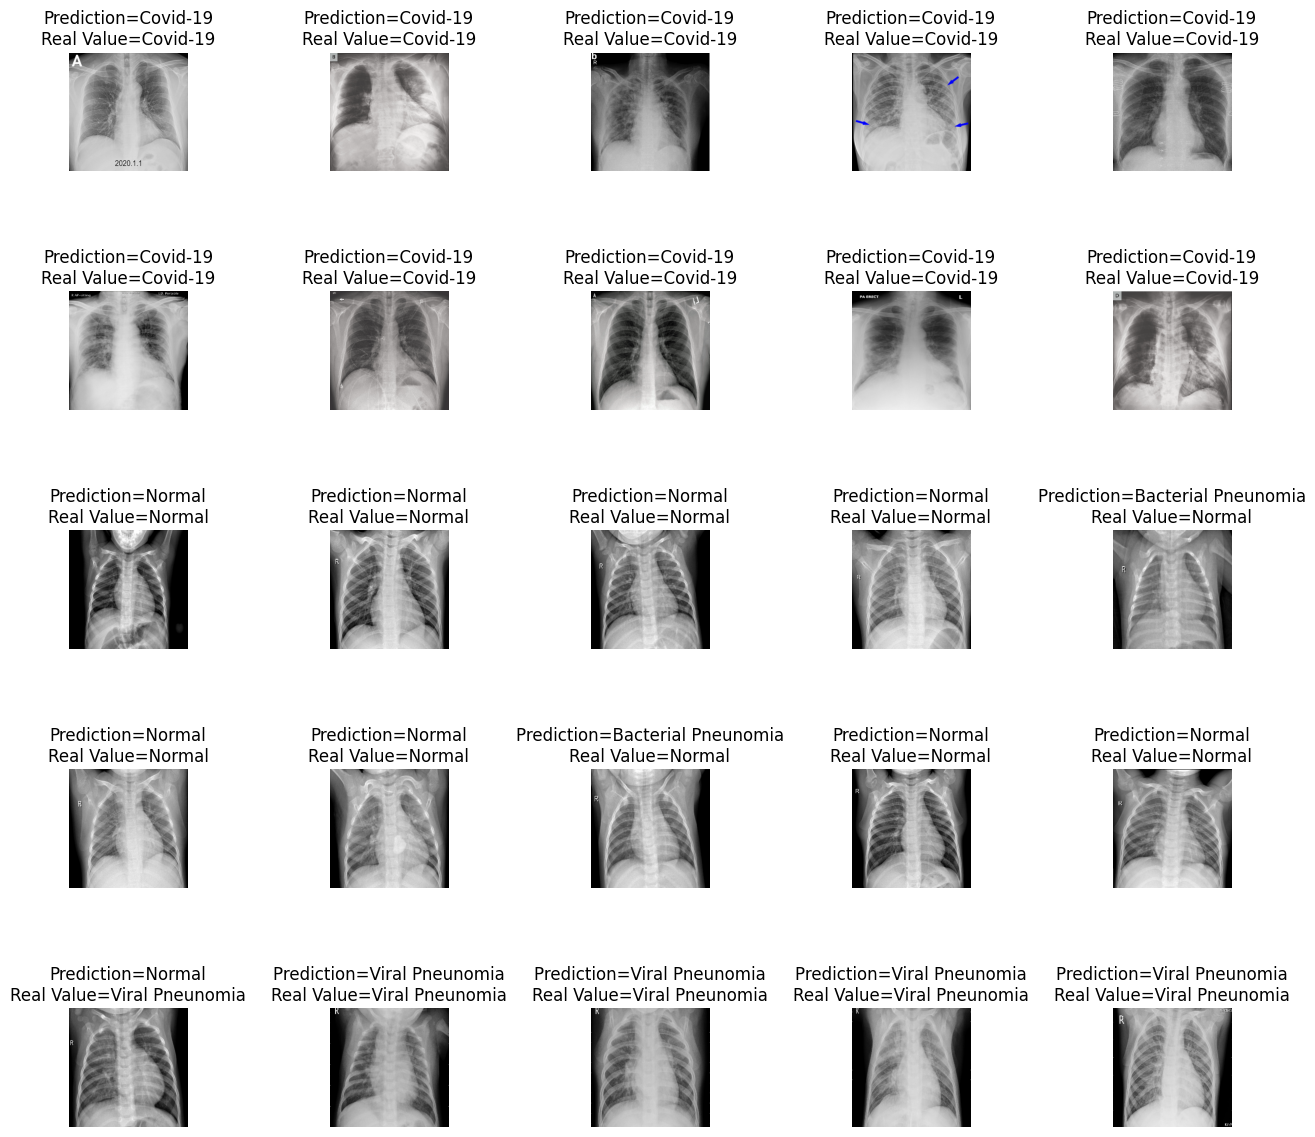

In [33]:
fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()
for i in np.arange(0, 25):
    axes[i].imshow(image[i])
    axes[i].set_title('Prediction={}\nReal Value={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
    axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)
plt.show()

In [34]:
labels_names

{0: 'Covid-19', 1: 'Normal', 2: 'Viral Pneunomia', 3: 'Bacterial Pneunomia'}

And finally, the confusion matrix

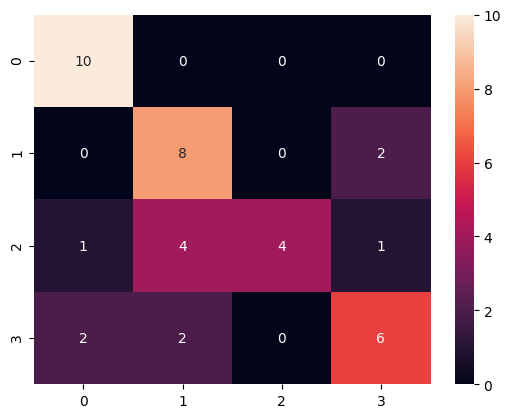

In [35]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);
plt.show()